In [109]:
# typing this quickly at the end of the day
# before I forget everything from my meeting with Greg

# we are going to calc theta first, then update H
# we're doing this for just two rock types - igneous and sedimentary

In [110]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [111]:
# SET UP GRID ARRAYS
dx = 1
x = np.arange(0, 100, dx)

# percentages in basin
amt_ig = 1
amt_sed = 0.0

# SET CONSTANTS
# characteristic alluvial thickness
Hstar = 2

# 1 - porosity
porosity = 0.55

# water discharge
q = x

# lumped factor, encapsulates roughness, grain size, etc. I have no idea what it's value should be...
c = 1

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = 0.004
beta_sed = 0.098

# SET UP TIME
num_steps = 1000
dt = (0.2 * dx * dx)/c

In [112]:
# write a function that has everything
def Bedrock_Alluvium(x,
                     dx,
                     q, 
                     num_steps,
                     amt_ig,
                     amt_sed,
                     beta_ig,
                     beta_sed,
                     k_low = 0.00001,
                     k_high = 0.001,
                     c = 1,
                     S = 0.001, 
                     porosity = 0.55,
                     Hstar = 2):
    
    """ The arguments to this function require the following data types:
        
        x : array
        dx : int
        q : array of length x
        num_steps : int
        amt_ig : float, < 1
        amt_sed : float, < 1
        (amt_ig + amt_sed should always = 1)
        beta_ig : float
        beta_sed : float
        k_low : float
        k_high : float
        c : float or int
        S : float or int
        porosity : float, < 1 
        Hstar : int """
    
    # create arrays of erodibilities
    k_ig = np.zeros(len(x))
    k_ig[:50] = k_low
    k_sed = np.zeros(len(x))
    k_sed[50:] = k_high
    
    # create arrays of bed abrasion coefficients
    bed_abrasion_ig = np.zeros(len(x))
    bed_abrasion_ig[:50] = beta_ig
    bed_abrasion_sed = np.zeros(len(x))
    bed_abrasion_sed[50:] = beta_sed
    
    # create array to hold elevations
    H_ig = np.zeros(len(x))
    H_sed = np.zeros(len(x))
    H = H_ig + H_sed
    H[-1] = 0
    etab = np.zeros(len(x))
    eta = etab + H
    ero = np.zeros(len(x))
    
    # create arrays to hold sediment fluxes
    qs = np.zeros(len(x))
    qs_ig = np.zeros(len(x))
    qs_sed = np.zeros(len(x))
    
    # create arrays to hold percentages of different lithologies
    theta = 1
    theta_ig = np.zeros(len(x))
    theta_sed = np.zeros(len(x))
    # theta_sed[:] = theta
    
    for i in range(num_steps):
        
        # calc slope
        S = np.diff(eta)/dx
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
    
        # calculate flux of each lithology
        qs_ig[1:] = qs[1:] * (theta_ig[:-1])
        qs_sed[1:] = qs[1:] * (theta_sed[:-1])
    
        # set constant, mixed feed of grains
        qs_ig[0] = amt_ig
        qs_sed[0] = amt_sed
        
        # update percentages based on alluvial thickness
        undefined = np.where(H == 0)
        defined = np.where(H != 0)
        
        theta_ig[undefined] = 0
        theta_ig[defined] += H_ig[defined]/H[defined]
        
        theta_sed[undefined] = 0
        theta_sed[defined] += H_sed[defined]/H[defined]
        
        # conserve mass
        theta_total = theta_ig + theta_sed
        dtheta = theta - theta_total
        theta_ig += dtheta * theta_ig
        theta_sed += dtheta * theta_sed
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        # ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (bed_abrasion_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (bed_abrasion_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        ero[:-1] = ero_plucking_ig + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= ero[:-1] * dt
        
        # calc grain attrition
        ig_atr = beta_ig * qs_ig[1:]
        sed_atr = beta_sed * qs_sed[1:]
        
        # calc change in alluvial thickness
        H_ig[:-1] += -((1 / porosity) * ((np.diff(qs_ig)/dx) + ig_atr - ero_plucking_ig)) * dt
        H_sed[:-1] += -((1 / porosity) * ((np.diff(qs_sed)/dx) + sed_atr)) * dt
        
        H[:-1] += H_ig[:-1] + H_sed[:-1]
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        return eta, etab, ero_plucking_ig, ero_ab_ig, ero_ab_sed, ero, H_ig, H_sed, H, theta_ig, theta_sed, theta

In [113]:
eta, 
etab, 
ero_plucking_ig, 
ero_plucking_sed, 
ero_ab_ig, 
ero_ab_sed, 
ero, 
H_ig, 
H_sed, 
H,
theta_ig, 
theta_sed, 
theta = Bedrock_Alluvium(x,
                         dx,
                         q,
                         500,
                         amt_ig,
                         amt_sed,
                         beta_ig,
                         beta_sed)

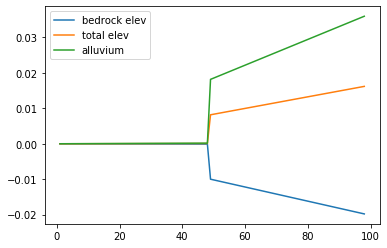

In [114]:
plt.plot(x[1:-1], etab[1:-1], label = 'bedrock elev')
plt.plot(x[1:-1], eta[1:-1], label = 'total elev')
plt.plot(x[1:-1], H[1:-1], label = 'alluvium')
plt.legend()
plt.show()


In [115]:
ero_plucking_ig

array([1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05, 7.0e-05,
       8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04, 1.4e-04,
       1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04, 2.1e-04,
       2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04, 2.8e-04,
       2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3.3e-04, 3.4e-04, 3.5e-04,
       3.6e-04, 3.7e-04, 3.8e-04, 3.9e-04, 4.0e-04, 4.1e-04, 4.2e-04,
       4.3e-04, 4.4e-04, 4.5e-04, 4.6e-04, 4.7e-04, 4.8e-04, 4.9e-04,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00])

In [118]:
ero[:-1] - ero_plucking_ig

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099])

In [119]:
ero_plucking_ig

array([1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05, 7.0e-05,
       8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04, 1.4e-04,
       1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04, 2.1e-04,
       2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04, 2.8e-04,
       2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3.3e-04, 3.4e-04, 3.5e-04,
       3.6e-04, 3.7e-04, 3.8e-04, 3.9e-04, 4.0e-04, 4.1e-04, 4.2e-04,
       4.3e-04, 4.4e-04, 4.5e-04, 4.6e-04, 4.7e-04, 4.8e-04, 4.9e-04,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00])

In [120]:
ero_ab_ig

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])